# Description
In this notebook, I ran inference on a set of about 20,000 images using the trained multi-label classification model and then evaluated the results. I set up a new, NC6_v3 machine for this because I needed more speed.

**Tiling**.  The image dimensions are roughly 4000 pixels X 6000 pixels, so they had to be cut into 'tiles' before doing inference.  Because I was in a hurry, I did a stopgap tiling job that involved writing tiles to disk, and it was very slow (12 hours for 1M tiles) on an Azure NC6 VM.  
**Inference**.  The inference itself only took about 1.75 hours on an Azure NC6_v3 (which has a V100 Nvidia GPU).   
**Evaluation**.  The inference results were summarized in two ways; 1)by tile, and 2) by fullsize image.  The latter required doing summary statistics on tiles.  In the process, we discovered two edge cases that increased the difficulty of counting results, but one of them seems to add some value as well.   
**Edge cases**:  
1. Tiles for which no category, not even the `empty` category, rose above the classification threshold.  That means the model looked at the tiles but did not classify them as anything.  We named this category 'uncertain' and later discovered that many of these contain interesting objects that are not included in our main category list.  Although the 'uncertain' category adds complication to the analysis, it seems to us at present that it worth keeping and investigating.  It is an indication that the model doesn't recognize any of the usual objects, but also isn't willing to certify that the tile as 'empty'.  
2. Tiles that are classified as _both_ `empty` _and_ containing some object.  There were only a few of these, and in this case we ignore the `empty` classification.

The implications are discussed in the Readme doc.

In [ ]:
import sys
from pathlib import Path
sys.path.insert(1,'/home/username')
print(sys.path)

import argparse
from time import perf_counter
import shutil
from collections import Counter, OrderedDict

import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import copy 
from PIL import Image

from lxml import etree as et
import re
#These are for PascalVOCWriter and PascalVOCReader
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs

from fastai.fastai.vision.all import *
from fastai.fastai.distributed import *

import trident_dev.tiling
import trident_dev.utilities

In [2]:
#Define filepaths
imagepath = Path('/cdata/tanzania/cormon')
workspace_path = Path('/cdata/tanzania/temp')

# Tile full-size images

In [5]:
testdir = Path('/cdata/tanzania/cormon')
tiledir = Path('/cdata/tanzania/cormon_tiles')
imagefile_extensions = ['.jpg','.JPG']

In [6]:
#Get list of files
tile_size = (800, 800) #H, W in pixels
tile_overlap = 100
testfiles = get_files(testdir,imagefile_extensions,recursive=False)
len(testfiles)

19402

## Tiling
This was a _very_ slow process; it took about 12 hours on an NC6 machine to produce 1M tiles from 20,000 images.  It was a stopgap measure because I haven't yet figured out how to pass in-memory tiles to a fastai dataloader.  I'm sure it could be easily improved on.

In [ ]:
#Tile them
tile_images(testfiles, tile_size, tile_overlap, tiledir)

working: 50000 tiles created...
working: 100000 tiles created...
working: 150000 tiles created...
working: 200000 tiles created...
working: 250000 tiles created...
working: 300000 tiles created...
working: 350000 tiles created...
working: 400000 tiles created...
working: 450000 tiles created...
working: 500000 tiles created...
working: 550000 tiles created...
working: 600000 tiles created...
working: 650000 tiles created...
working: 700000 tiles created...
working: 750000 tiles created...
working: 800000 tiles created...
working: 850000 tiles created...
working: 900000 tiles created...
working: 950000 tiles created...


#### Got interrupted by auto-shutdown
The next few cells are just counting to figure out where it stopped, and then finishing the job.  I've left it in because this kind of problem is typical.

In [15]:
#Get filenames of the ones that were done
tile_filestems = [Path(re.search("^(.*?)\[\d+\]\[\d+\]",f).group(1)).stem for f in tile_files] #convert strings to Paths and get parent folder
len(tile_filestems), tile_filestems[:5]


(972337,
 ['wcm_n51_R_20190602102420',
  'wcm_n51_R_20190603111214',
  'wcm_n51_L_20190603115842',
  'wcm_n51_L_20190603125508',
  'wcm_n51_L_20190602104344'])

In [21]:
#the set of fullsize image filenames that were done
already_tiled = list(set(tile_filestems))
len(already_tiled)

18007

In [26]:
#Find the names that were done, excluding any that weren't finished (tile count < 54)
values, counts = np.unique(tile_filestems, return_counts=True)
tmp = [(x,y) for x,y in zip(values,counts)]
donelist = [t[0] for t in tmp if t[1]==54]
len(donelist)

18006

In [27]:
#Get the stems from the full list
allfiles = [Path(x).stem for x in testfiles]
len(allfiles)

19402

In [30]:
#Take the difference to find the missing files
not_done = list(set(allfiles) - set(donelist)) 
len(not_done)

1396

In [35]:
#Find the matching full paths
not_donepaths = [x for x in testfiles if Path(x).stem in not_done]
len(not_donepaths),not_donepaths[:5]

(1396,
 ['/cdata/tanzania/cormon/wcm_n51_L_20190603123206.jpg',
  '/cdata/tanzania/cormon/wcm_n51_R_20190603121752.jpg',
  '/cdata/tanzania/cormon/wcm_n51_L_20190603102936.jpg',
  '/cdata/tanzania/cormon/wcm_n51_R_20190602100948.jpg',
  '/cdata/tanzania/cormon/wcm_n51_L_20190602111632.jpg'])

In [36]:
#Finally, tile the rest
tile_images(not_donepaths, tile_size, tile_overlap, tiledir)

working: 50000 tiles created...
Saved 75384 tiles to  /cdata/tanzania/cormon_tiles from  1396 full-sized images.


# Create a dataloader
**NOTE** Loading a fastai model from a pickle file is not always smooth.  I didn't have to actually create a dataloader, but I _did_ have to run the `get_x` and `get_y` functions to get the model to load.  

In [8]:
#These functions define how X and Y (image and labels) are extracted from the dataframe: 
#add the path to X (filenames) and split Y (labels) on spaces.
def get_x(r): return imagepath/r['filename']
def get_y(r): return r['labels'].split(' ')

In [9]:
tst_files = get_image_files(tiledir)
len(tst_files)

1047708

In [39]:
19402 * 54

1047708

# Load the pretrained model
The `cpu=False` parameter on `load_learner` is absolutely critical: the default is for inference to be done on the CPU.

In [10]:
saved_model = '/home/jp/models/model_2021_jul18_best.pkl'
learn = load_learner(saved_model,cpu=False)

In [11]:
tst_dl = learn.dls.test_dl(tst_files) #Create the test dataloader.  

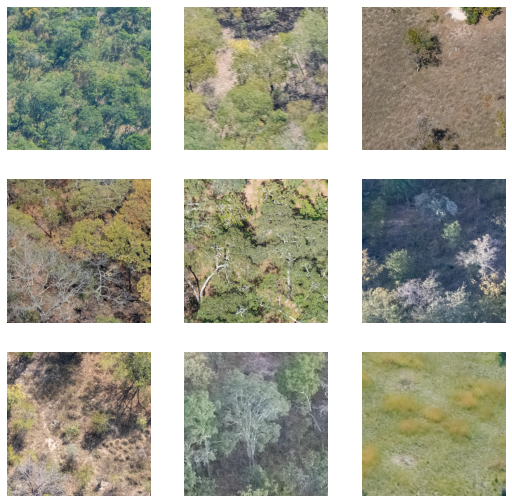

In [12]:
tst_dl.show_batch()

In [13]:
dls = learn.dls

In [15]:
#check to make sure it didn't forget the categories
dls.vocab

['', 'buffalo', 'building', 'charcoal_mound', 'charcoal_sack', 'cow', 'donkey', 'eland', 'elephant', 'gazelle', 'giraffe', 'hartebeest', 'human', 'impala', 'kudu', 'oryx', 'other_animal', 'shoats', 'warthog', 'wildebeest', 'zebra']

In [47]:
#check a tile (it's empty)
learn.predict(tst_files[0])

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


((#1) [''],
 tensor([ True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False]),
 tensor([9.8932e-01, 9.6374e-04, 4.2352e-06, 3.6983e-06, 3.5713e-06, 5.1361e-05,
         1.9670e-06, 4.5114e-06, 3.6798e-03, 2.8081e-06, 3.1413e-05, 1.3722e-05,
         9.9920e-04, 2.7808e-05, 4.8886e-05, 5.0752e-07, 9.0309e-06, 1.5152e-05,
         8.3862e-06, 7.7500e-05, 4.5535e-04]))

In [16]:
#Make sure the model is actually on the GPU
next(learn.model.parameters()).is_cuda

True

# Predict

In [ ]:
#PREDICT 'TEST' DATASET
tic1 = time.perf_counter()
preds,targs = learn.get_preds(dl=tst_dl)
tic2 = time.perf_counter()
print("Inference done in {:.2f}s".format(tic2 - tic1))
print(preds.shape)

#These were the results:
# Inference done in 6388.69s
# torch.Size([1047708, 21])

thresh = 0.5
bin_preds = torch.gt(preds, thresh).int()

In [23]:
#Calculate seconds/image (it was .002 for a much smaller dataset)
6388/1047708

0.0060971186628335375

In [42]:
#These are the prediction scores that the model outputs
preds[:2]

tensor([[8.6306e-01, 6.4956e-04, 8.2443e-04, 1.6015e-05, 1.9343e-04, 7.7414e-04,
         2.5317e-05, 1.3832e-03, 2.2188e-04, 5.9864e-05, 7.3739e-03, 6.6158e-03,
         2.2307e-03, 2.5247e-04, 1.5812e-05, 2.5829e-05, 4.3319e-02, 1.7012e-03,
         8.3332e-06, 1.2244e-04, 3.4593e-03],
        [8.0275e-01, 2.8880e-02, 7.6507e-03, 1.0175e-03, 2.4073e-03, 8.6386e-03,
         1.5905e-04, 2.0053e-03, 8.3117e-03, 3.6854e-05, 1.4835e-02, 6.0284e-04,
         1.5342e-02, 6.6273e-04, 9.0817e-04, 2.8393e-04, 1.8407e-02, 5.5889e-03,
         2.9081e-04, 2.1220e-03, 7.2803e-03]])

In [50]:
#Convert to binary (0/1) predictions
thresh = 0.5
bin_preds = torch.gt(preds, thresh).int()
bin_preds

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

## Save predictions to file

In [ ]:
colnames = dls.vocab
colnames[0] = 'empty'
rownames = [Path(t).name for t in tst_files]

#Save targets (REMINDER: there may not be targets if it's a test dataset.)
#save_tensor_to_csv(targs,workspace_path/"targets.csv") 

#Save predictions (On 1M rows, binary preds took a couple of seconds and the file is 77Mb; scores also pretty quick but file is 310 Mb)
save_tensor_to_csv(preds,workspace_path/"predictions_allcormon.csv",rownames,colnames)
bpred = save_tensor_to_csv(bin_preds,workspace_path/"binary_predictions_allcormon.csv",rownames,colnames)

### Extract filename, tile_row and tile_col

In [26]:
bpx = bpred.index.tolist()

In [27]:
fname = [Path(re.search("^(.*?)\[\d+\]\[\d+\]",f).group(1)).stem for f in bpx]
tile_row = [int(re.search("\[(\d+)\]\[(\d+)\]",f).group(1)) for f in bpx]
tile_col = [int(re.search("\[(\d+)\]\[(\d+)\]",f).group(2)) for f in bpx]

### Add them to the prediction file

In [ ]:
bpred.insert(0, 'filename', fname)
bpred.insert(1,'tile_row',tile_row)
bpred.insert(2,'tile_col',tile_col)
bpred.sort_values(['filename','tile_row','tile_col'],ascending=True,inplace=True)

### Save the tile predictions

In [29]:
bpred.to_csv('tile_predictions_allcormon.csv')

In [82]:
bpred.columns

Index(['filename', 'tile_row', 'tile_col', 'empty', 'buffalo', 'building',
       'charcoal_mound', 'charcoal_sack', 'cow', 'donkey', 'eland', 'elephant',
       'gazelle', 'giraffe', 'hartebeest', 'human', 'impala', 'kudu', 'oryx',
       'other_animal', 'shoats', 'warthog', 'wildebeest', 'zebra'],
      dtype='object')

### Reload predictions file (if necessary) 

In [18]:
bpred = pd.read_csv('/home/jp/results/fastai/tile_predictions_allcormon.csv',keep_default_na=False) 
bpred.drop('Unnamed: 0', axis=1,inplace=True) #drop index row
bpred

,filename,tile_row,tile_col,empty,buffalo,building,charcoal_mound,charcoal_sack,cow,donkey,...,hartebeest,human,impala,kudu,oryx,other_animal,shoats,warthog,wildebeest,zebra
0,wcm_n51_L_20190602095310,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,wcm_n51_L_20190602095310,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,wcm_n51_L_20190602095310,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,wcm_n51_L_20190602095310,0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,wcm_n51_L_20190602095310,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047703,wcm_n51_R_20190603125650,5,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047704,wcm_n51_R_20190603125650,5,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047705,wcm_n51_R_20190603125650,5,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047706,wcm_n51_R_20190603125650,5,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Write XML annotation files

One of the recurring challenges in our workflow is figuring out how to share results with colleagues for checking.  The classification model doesn't output bounding boxes; it just tells you what is in each tile. But for visualization, it would be nice to show a full-sized image and somehow highlight the tiles that have objects in them.  Our simple solution was to create "bounding boxes" that are actually just tile boundaries, and save them as Pascal-VOC=style XML annotation files; one per full-sized image.  That way, the user can load the full-size image and a corresponding xml file into a program like CVAT, and it will put a labeled box around each of the relevant tiles.

In [10]:
#Get filename stems from the binary predictions file
predfiles = bpred.filename.unique()
len(predfiles), predfiles[0]

(19402, 'wcm_n51_L_20190602095310')

In [42]:
#Get a list of the full-size image filepaths from the filesystem
imagefile_extensions = ['.jpg','.JPG']
images = get_files(imagepath,imagefile_extensions,recursive=False)
len(images)

19402

In [50]:
#Write XML files for each of the full-size images
tile_size = (800,800)
overlap = 100
outdir = '/cdata/tanzania/cormon_xml'
for fstem in predfiles:
    fpath = find_imagepath_from_stem(images,fstem) #go find the filepath
    width,height = get_image_size(fpath)
    imagefile = Path(fpath).name
    write_xml_for_fullimage(bpred,imagefile,width,height,tile_size,overlap,outdir)

In [51]:
#Check to see how many were written
xml_files = get_files(outdir,['.xml'],recursive=False)
len(xml_files)

13363

# Summarize results
The results of the classification model are summarized below in two ways: 1) by tile, and 2) by full-size file. As soon as we did, we discovered an edge case: 'uncertain' predictions.

### We discover an edge case: uncertain predictions.  
Is something wrong with the summary, or are there really files where no category rises above the threshold?  we check an 'uncertain' tile to make sure.

In [313]:
#Yes, uncertainty appears to be a real thing: the model doesn't like ANY of the categories including 'empty'
learn.predict(Path(tiledir)/'CP1_4703 Ground hornbill[0][5].jpg')

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False]),
 tensor([7.5316e-02, 2.5431e-02, 2.0583e-03, 2.1892e-05, 1.4458e-03, 4.9006e-04,
         4.0537e-05, 3.4531e-06, 6.8677e-03, 1.5073e-06, 7.8519e-05, 2.1630e-06,
         8.2357e-03, 3.9365e-06, 2.1505e-05, 6.9440e-06, 3.5868e-02, 5.1133e-02,
         8.7538e-06, 1.7981e-06, 1.1854e-03]))

## Summary by tile
First, we summarize results by tile.  But when we did, we discovered an edge case: tiles that weren't classified as anything.

### Calculate number of categories per file
Note: we create this from the binary predictions file, bpred, but **we don't add it to bpred** because it's a derived value (not data), and will make other calculations more difficult if included.

In [76]:
cols_to_sum = bpred.columns[3:]
n_categories = bpred[cols_to_sum].sum(axis=1)
len(n_categories),

[(x,len(n_categories[n_categories.values==x])) for x in range(4)]

[(0, 50567), (1, 993863), (2, 3278), (3, 0)]

How many categories did each tile include?
- 0 (= "uncertain"): 50567 (4.82%)
- 1 (either empty or has one object): 993863 (94.86%)
- 2 (two categories): 3278 (0.31%)
- 3 (three categories): 0

In [83]:
#How many tiles were empty?
len(bpred[bpred['empty']==1])

981005

In [84]:
#What proportion of the total tiles are empty?
981005/1047708

0.9363343603370404

In [86]:
#Number of tiles with at least one object (all 1's - empties + all 2's)
993863 - 981005 + 3278

16136

In [87]:
#Total tiles that will have to be examined by humans (objects + uncertain tiles)
16136 + 50567

66703

In [88]:
#Number to be examined a proportion of the total
66703/1047708

0.06366563966295953

#### Calculate number of tiles per category

In [83]:
#For each category, count number of tiles that are predicted to contain that category
[(cat,len(bpred[bpred[cat]==True])) for cat in bpred.columns[4:]]

[('buffalo', 120),
 ('building', 1784),
 ('charcoal_mound', 0),
 ('charcoal_sack', 0),
 ('cow', 6867),
 ('donkey', 0),
 ('eland', 22),
 ('elephant', 3579),
 ('gazelle', 625),
 ('giraffe', 74),
 ('hartebeest', 98),
 ('human', 1179),
 ('impala', 1414),
 ('kudu', 0),
 ('oryx', 0),
 ('other_animal', 2465),
 ('shoats', 116),
 ('warthog', 0),
 ('wildebeest', 201),
 ('zebra', 870)]

## Summarize results by full-sized image
Now we sum the tile results for each full-size image, and because of the edge cases, the counting gets complicated.

First, we create a summary file with the fullsized image filename plus a description string.  The description is a shorthand for what is in each image, a string in the form:  
`[tile row][tile col]: category1 category2...`  
(see example below)

If all tiles are empty, then the image is labeled as `empty`.  Unfortunately, there is an edge case, which is that none of the category scores including 'empty' exceed the detection threshold, in which case the tile is labeled as `uncertain`.

In [30]:
fnames = bpred.filename.unique() #These are stem only (no path or extension)
len(fnames)

19402

In [57]:
#Get a string description of each image file by compiling information about its tiles
descriptions = [(f,describe_image(bpred,f)) for f in predfiles]
file_descriptions = pd.DataFrame(descriptions, columns =['image_name', 'description']) 
file_descriptions.to_csv('file_descriptions_allcormon.csv')
file_descriptions

,image_name,description
0,wcm_n51_L_20190602095310,[2][6]:uncertain
1,wcm_n51_L_20190602095312,[5][3]:uncertain
2,wcm_n51_L_20190602095314,empty
3,wcm_n51_L_20190602095316,empty
4,wcm_n51_L_20190602095318,empty
...,...,...
19397,wcm_n51_R_20190603125642,[0][6]:uncertain [0][7]:uncertain [1][1]:uncertain [4][3]:uncertain [4][6]:uncertain [4][7]:uncertain [5][0]:uncertain [5][6]:uncertain
19398,wcm_n51_R_20190603125644,[0][1]:uncertain [0][6]:uncertain [1][2]:uncertain [2][3]:uncertain [2][8]:uncertain [5][0]:cow
19399,wcm_n51_R_20190603125646,[0][0]:uncertain [0][1]:uncertain [0][5]:uncertain [1][5]:uncertain [2][6]:human [4][0]:uncertain [4][5]:uncertain [5][5]:uncertain
19400,wcm_n51_R_20190603125648,[0][2]:uncertain [0][7]:uncertain [1][1]:uncertain [4][7]:cow [4][8]:uncertain


In [59]:
#What proportion of the total full-size images are empty?
len(file_descriptions[file_descriptions['description']=='empty']); 6039/19402

0.31125657148747554

### Divide full-size images into categories based on results

In [92]:
#Do the calculation
fullcounts = []
for f in predfiles:
    fullcounts.append(fullsize_stats(f,bpred))
fcounts = pd.DataFrame(fullcounts, columns =['is_empty','has_objects','has_elephants','is_uncertain'])
fcounts.insert(0,'filename',predfiles)
fcounts.to_csv('/home/jp/results/fastai/fcounts.csv')
fcounts                       
sum(fcounts.is_empty),sum(fcounts.has_objects),sum(fcounts.has_elephants),sum(fcounts.is_uncertain)

(6039, 6256, 1883, 7107)

In [93]:
fcounts

,filename,is_empty,has_objects,has_elephants,is_uncertain
0,wcm_n51_L_20190602095310,False,False,False,True
1,wcm_n51_L_20190602095312,False,False,False,True
2,wcm_n51_L_20190602095314,True,False,False,False
3,wcm_n51_L_20190602095316,True,False,False,False
4,wcm_n51_L_20190602095318,True,False,False,False
...,...,...,...,...,...
19397,wcm_n51_R_20190603125642,False,False,False,True
19398,wcm_n51_R_20190603125644,False,True,False,False
19399,wcm_n51_R_20190603125646,False,True,False,False
19400,wcm_n51_R_20190603125648,False,True,False,False


### Merge file description strings with boolean columns

In [ ]:
file_descriptions = pd.read_csv('/home/jp/results/fastai/file_descriptions_allcormon.csv')
file_descriptions.drop('Unnamed: 0',inplace=True,axis=1)

In [107]:
fcounts.rename({'filename':'image_name'},inplace=True,axis=1)
fullsummarydf = fcounts.merge(file_descriptions, on='image_name', how='left')
fullsummarydf.to_csv('/home/jp/results/fastai/fullsummarydf.csv') #Renamed "Cormon summary by file.csv" on my laptop

In [106]:
fullsummarydf

,image_name,is_empty,has_objects,has_elephants,is_uncertain,description
0,wcm_n51_L_20190602095310,False,False,False,True,[2][6]:uncertain
1,wcm_n51_L_20190602095312,False,False,False,True,[5][3]:uncertain
2,wcm_n51_L_20190602095314,True,False,False,False,empty
3,wcm_n51_L_20190602095316,True,False,False,False,empty
4,wcm_n51_L_20190602095318,True,False,False,False,empty
...,...,...,...,...,...,...
19397,wcm_n51_R_20190603125642,False,False,False,True,[0][6]:uncertain [0][7]:uncertain [1][1]:uncertain [4][3]:uncertain [4][6]:uncertain [4][7]:uncertain [5][0]:uncertain [5][6]:uncertain
19398,wcm_n51_R_20190603125644,False,True,False,False,[0][1]:uncertain [0][6]:uncertain [1][2]:uncertain [2][3]:uncertain [2][8]:uncertain [5][0]:cow
19399,wcm_n51_R_20190603125646,False,True,False,False,[0][0]:uncertain [0][1]:uncertain [0][5]:uncertain [1][5]:uncertain [2][6]:human [4][0]:uncertain [4][5]:uncertain [5][5]:uncertain
19400,wcm_n51_R_20190603125648,False,True,False,False,[0][2]:uncertain [0][7]:uncertain [1][1]:uncertain [4][7]:cow [4][8]:uncertain


### Create df to split tiles into groups
At this point, we have created 1 million tile annotations.  For practical purposes, we are likely to want to separate the original full-sized images into groups: those with all empty tiles; the images in which at least 1 tile contains an object; and images that are a mix of "uncertain" and "empty" tiles.  Since the data are recorded by tile, this is slightly tricky.

In [37]:
#Calculate tiles per 
#These WORK
is_empty = bpred.apply(lambda x: x['empty']==1, axis=1) 
has_object = bpred.apply(lambda x: sum(x[4:])>0, axis=1) 
is_uncertain = bpred.apply(lambda x: sum(x[3:])==0, axis=1)

#Create a dataframe and save it to disk
tilecats = pd.DataFrame(bpred.iloc[:,:3])
tilecats=tilecats.assign(is_empty=is_empty)
tilecats=tilecats.assign(has_object=has_object)
tilecats=tilecats.assign(is_uncertain=is_uncertain)
tilecats
tilecats.to_csv('/home/jp/results/fastai/tile categories.csv')

In [41]:
sum(tilecats.has_object),sum(tilecats.is_empty),sum(tilecats.is_uncertain)

(19313, 981005, 50567)

In [76]:
tilecats = pd.read_csv('/home/jp/results/fastai/tile categories.csv')

In [77]:
tilecats.drop(['Unnamed: 0'],axis=1,inplace=True)
tilecats[tilecats.has_object==True]

,filename,tile_row,tile_col,is_empty,has_object,is_uncertain
252,wcm_n51_L_20190602095318,4,0,True,True,False
330,wcm_n51_L_20190602095322,0,6,False,True,False
339,wcm_n51_L_20190602095322,1,6,True,True,False
347,wcm_n51_L_20190602095322,2,5,True,True,False
366,wcm_n51_L_20190602095322,4,6,True,True,False
...,...,...,...,...,...,...
1047570,wcm_n51_R_20190603125646,2,6,False,True,False
1047643,wcm_n51_R_20190603125648,4,7,False,True,False
1047661,wcm_n51_R_20190603125650,0,7,False,True,False
1047662,wcm_n51_R_20190603125650,0,8,False,True,False


### Aaaargh, _another_ edge case (empty _and_ has objects)
We will just ignore the 'empty' label in these cases.

In [78]:
len(tilecats[(tilecats['is_empty']==True) & (tilecats['has_object']==True)])

3177

## Copy tiles to blobstore for analysis by Detectron2
The next step in the analysis pipeline is to copy the tiles from the classification model to a place where they can be analyzed by the Detectron2 bounding box model.  

The classification model does not output bounding boxes for these tiles, so all we need to do is to select a set of tiles that will be treated like a test set for Detectron2.  We take all tiles with animals and all uncertain tiles, plus a sample of empty tiles.

#### Copy the sample tiles to a separate directory
More file management stupidity; I only did this because it's a lot easier to transfer files to blob storage for the Detectron2 model if they are in a clean directory.

### First, copy the tiles to a separate directory for upload
This is the inefficient way to do it.  We plan to port the fastai model code to the Azure ML Python SDK, and to move the files to blobstorage during the tile creation step so that they can all be linked in an Azure pipeline.  For now, we upload them manually.

In [123]:
isempty_tiles = tilecats[tilecats['is_empty']==True].sample(n=1000, random_state=123).index
hasobject_tiles = tilecats[tilecats['has_object']==True].index
isuncertain_tiles = tilecats[tilecats['is_uncertain']==True].index
tilesampleindex = isempty_tiles.append([hasobject_tiles,isuncertain_tiles])
fulltilesample = tilecats.loc[tilesampleindex]

In [128]:
#Add a column for tilename (just to save time)
t = fulltilesample
fulltilesample['tilename'] = t.apply(lambda r: r.loc['filename'] +  '[' + str(r.tile_row) + ']' + '[' + str(r.tile_col) + ']' + '.jpg',axis=1)

In [129]:
len(fulltilesample)

70880

#### Copy the sample tiles to a separate directory
More file management inefficiency; I only did this because it's a lot easier to transfer files to blob storage for the Detectron2 model if they are in a clean directory.

In [131]:
cormontiles = Path('/cdata/tanzania/cormon_tiles')
destdir = Path('/cdata/tanzania/cormon_sample/export')
for i in range(len(fulltilesample)):
    shutil.copy2(Path(cormontiles)/fulltilesample.iloc[i].tilename, destdir) # complete target filename given

#### Create a database with the details for the sample
Handy for bookkeeping.

In [132]:
fullsampledf = fulltilesample.merge(bpred,on=['filename','tile_row','tile_col'],how='left')
fullsampledf.to_csv('/home/jp/results/fastai/cormon_fullsampledf.csv')